## Probabilisitic Linear Discriminant Analysis (PLDA) applied to x-vector embeddings

In our numerical implementation, we'll use an opensource [speechbrain](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.processing.PLDA_LDA.html#speechbrain.processing.PLDA_LDA.Ndx) library for PLDA, sklearn for PCA and methods from numpy, scipy for efficient handling of calculations. 

## X-vector embeddings

### 1. Import libraries and load the data.

In [2]:
import pandas as pd
import numpy as np
from speechbrain.processing.PLDA_LDA import PLDA, StatObject_SB

xv_df = pd.read_csv('embeddings/x_vector_embeddings.csv', low_memory=False)
veri_test = pd.read_csv('embeddings/veri_test.txt', sep=' ', header=None, names=['label', 'enroll_id', 'test_id'])

### 2. Split train and test data.

In [3]:
embedding_map = {row['file_id']: row.iloc[1:].values for _, row in xv_df.iterrows()}
veri_test_speaker_ids = set(veri_test['enroll_id'].apply(lambda x: x.split('/')[0])) \
                        .union(set(veri_test['test_id'].apply(lambda x: x.split('/')[0])))

In [4]:
from helpers import partition_speaker_ids, get_speechbrain_sets

train_embeddings, train_speaker_ids = partition_speaker_ids(embedding_map, veri_test_speaker_ids)
modelset, segset = get_speechbrain_sets(embedding_map, train_speaker_ids)

#Sanity checks
assert len(modelset) == len(train_embeddings) and len(segset) == len(train_embeddings)

### 3. Perform PCA.

Even though PLDA is a dimensionality reduction technique by itself, combining it with Principal Component Analysis makes the model even more robust. This is because:

1. Linear Discriminant Analysis (LDA) is a more complex technique that, apart from simply reducing dimensinality of the data, maximises between-class and within-class covariances ($S_b$ and $S_w$). Moreover, Probabilistic variations of LDA can generate data classes centers using funcitions of different complexities, including those that are non-linear. This all can significantly impact the speed of calculations. So we chose not to perform those on $512$-dimensional data. 

2. Before even training the model, PCA can extract more meaningful chunks of data for us by keeping only those dimensions that represent highly variable chunks of data. As a result, we train PLDA model on less amount of noise and more concentrated data.

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.8)
pca.fit(train_embeddings)
train_trans_embs = pca.transform(train_embeddings)

ndim = train_trans_embs[0].shape[0]
print(f'PCA reduced training data to {ndim} dimensions.')

PCA reduced training data to 40 dimensions.


As we see, by keeping only $80\%$ of explained variance, we managed to greatly reduce our train dataset from $512$ to $40$ dimensions.

### 4. Training of PLDA model.

The speechbrain implementation of PLDA training estimates the main model parameters  $\mu$, $\Phi$ and $\Sigma$ using the Expectation-Maximization (EM) algorithm:

1. First we initialise $\mu$ and $\Sigma$ using the empirical mean and covariance of the training embeddings. $\Phi$ is initialised using eigendecomposition.

2. Then we estimate the posterior distribution of the speaker identity varialbe given the observed embeddings and the current estimates of the PLDA parameters (E-step).

3. Update the parameters $\Phi$ and $\Sigma$ using the estimated posterior distribution from E-step.

4. Repeat steps 2 and 3 until convergence.

In [6]:
stat0 = np.array([[1.0]] * len(train_trans_embs))
stat1 = train_trans_embs.astype(np.float64)  

xvectors_stat = StatObject_SB(modelset=modelset, segset=segset, start=None, stop=None, stat0=stat0, stat1=stat1)

plda = PLDA(rank_f=ndim)
plda.plda(xvectors_stat)

np.savez('models/xv-plda.npz', mean=plda.mean, F=plda.F, Sigma=plda.Sigma)

### 5. Subsetting enroll and test data and reducing their dimensions.

Here we apply the same PCA transformation to the enroll and test data as we did to the train data.

In [7]:
en_embeddings = np.array([embedding_map.get(enroll_id) for enroll_id in veri_test['enroll_id']])
te_embeddings = np.array([embedding_map.get(test_id) for test_id in veri_test['test_id']])

en_embeddings, te_embeddings = pca.transform(en_embeddings), pca.transform(te_embeddings)

### 6. Scoring for enroll and test data.

In [8]:
from scipy.spatial.distance import mahalanobis
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def log_likelyhood_score(enrollment_embeddings, test_embeddings, mu, F, Sigma):

    inv_Sigma = np.linalg.inv(Sigma)
    inv_phi = np.linalg.inv(F.T @ inv_Sigma @ F + np.eye(F.shape[1]))
    scores = []

    for enroll_emb, test_emb in zip(enrollment_embeddings, test_embeddings):
        enroll_emb_cent = enroll_emb - mu
        test_emb_cent = test_emb - mu
        
        v1 = inv_Sigma @ enroll_emb_cent
        v2 = inv_Sigma @ test_emb_cent

        t1 = v1.T @ inv_phi @ F.T @ v2
        t2 = v1.T @ inv_phi @ v1 / 2
        t3 = v2.T @ inv_phi @ v2 / 2
        
        score = t1 - t2 - t3
        scores.append(score)
    
    return np.array(scores)

def compute_eer(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    eer_threshold = thresholds[np.nanargmin(np.absolute((1 - tpr) - fpr))]
    eer = fpr[np.nanargmin(np.absolute((1 - tpr) - fpr))]
    return eer, eer_threshold

In [9]:
plda_params = np.load('models/xv-plda.npz')
mean = plda_params['mean']
Sigma = plda_params['Sigma']
F = plda_params['F']

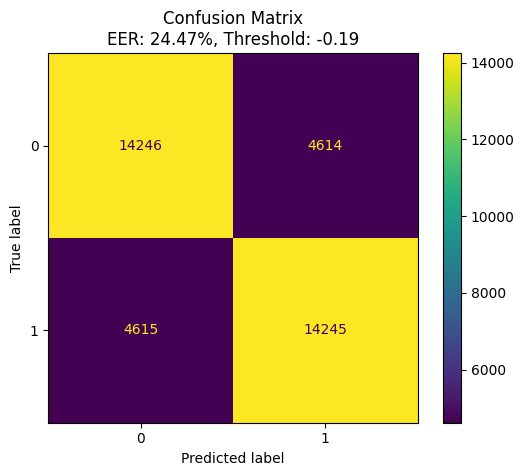

In [10]:
scores = log_likelyhood_score(en_embeddings, te_embeddings, mean, F, Sigma)
labels = veri_test['label'].values

eer, threshold = compute_eer(labels, scores)
predicted_labels = (scores > threshold).astype(int)
conf_matrix = confusion_matrix(labels, predicted_labels)

disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()
plt.title(f'Confusion Matrix\nEER: {eer:.2%}, Threshold: {threshold:.2f}')
plt.show()

## Spectrogram embeddings